In [87]:
import os
import numpy
import time
import random
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats
import matplotlib.offsetbox as offsetbox
from matplotlib.ticker import StrMethodFormatter



def saver(fname,dpi=600):
    plt.savefig(fname+".png",bbox_inches="tight",dpi=dpi)
    
def legend(pos="bottom",ncol=3,extra=False):
    if pos=="bottom":
        extra = 0.15 if extra else 0
        plt.legend(bbox_to_anchor=(0.5,-0.2-extra), loc='upper center',facecolor="lightgray",ncol=ncol)
    elif pos=="side":
        plt.legend(bbox_to_anchor=(1.1,0.5), loc='center left',facecolor="lightgray",ncol=1)
        
def textbox(txt,fname=None):
    plt.figure(figsize=(1,1))
    plt.gca().add_artist(offsetbox.AnchoredText("\n".join(txt), loc="center",prop=dict(size=30)))
    plt.axis('off')
    if fname is not None:
        saver(fname)
    plt.show()
    plt.close()

In [88]:
import pandas as pd
def getfile(location_pair,**kwargs): #tries to get local version and then defaults to google drive version
    (loc,gdrive)=location_pair
    try:
        out=pd.read_csv(loc,**kwargs)
    except FileNotFoundError:
        print("local file not found; accessing Google Drive")
        loc = 'https://drive.google.com/uc?export=download&id='+gdrive.split('/')[-2]
        out= pd.read_csv(loc,**kwargs)
    return out

import urllib
def getLargeFile(location_pair,**kwargs): #tries to get local version and then defaults to google drive version
    (loc,gdrive)=location_pair
    try:
        out=pd.read_csv(loc,**kwargs)
    except FileNotFoundError:
        print("local file not found; accessing Google Drive")
        url = gdrive
        urllib.request.urlretrieve(gdrive, loc)
        out= pd.read_csv(loc,**kwargs)
    return out

fname = ("Crime_Data_from_2020_to_Present.csv", 
         "https://drive.google.com/u/0/uc?id=1WwLkX_BADtPY83rFQ4CQ5Lbf6UcI055A&export=download&confirm=t&uuid=4e0aae58-2f5b-4420-941f-8f2f49ae0cb8&at=ALAFpqzX_FrSz-hUtqhaXe2ui7h6:1667673013562")
data = getLargeFile(fname)
data.head()

,DR_NO,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Part 1-2,Crm Cd,Crm Cd Desc,...,Status,Status Desc,Crm Cd 1,Crm Cd 2,Crm Cd 3,Crm Cd 4,LOCATION,Cross Street,LAT,LON
0,10304468,01/08/2020 12:00:00 AM,01/08/2020 12:00:00 AM,2230,3,Southwest,377,2,624,BATTERY - SIMPLE ASSAULT,...,AO,Adult Other,624.0,NaN,NaN,NaN,1100 W 39TH PL,NaN,34.0141,-118.2978
1,190101086,01/02/2020 12:00:00 AM,01/01/2020 12:00:00 AM,330,1,Central,163,2,624,BATTERY - SIMPLE ASSAULT,...,IC,Invest Cont,624.0,NaN,NaN,NaN,700 S HILL ST,NaN,34.0459,-118.2545
2,200110444,04/14/2020 12:00:00 AM,02/13/2020 12:00:00 AM,1200,1,Central,155,2,845,SEX OFFENDER REGISTRANT OUT OF COMPLIANCE,...,AA,Adult Arrest,845.0,NaN,NaN,NaN,200 E 6TH ST,NaN,34.0448,-118.2474
3,191501505,01/01/2020 12:00:00 AM,01/01/2020 12:00:00 AM,1730,15,N Hollywood,1543,2,745,VANDALISM - MISDEAMEANOR ($399 OR UNDER),...,IC,Invest Cont,745.0,998.0,NaN,NaN,5400 CORTEEN PL,NaN,34.1685,-118.4019
4,191921269,01/01/2020 12:00:00 AM,01/01/2020 12:00:00 AM,415,19,Mission,1998,2,740,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",...,IC,Invest Cont,740.0,NaN,NaN,NaN,14400 TITUS ST,NaN,34.2198,-118.4468


### Problem  Description

* Purpose: From the initial analysis, we find that `TIME OCC`,and `Vict Age` are some of important features that affects the label `Victim Sex`. Therefore, by using this logist regression model, we want to discuss the relation between these features and the number of crimes.
* Features:
  * Scalar Features:
    * Victim Age
    * Latitude
    * Longitude

  * Categorical Features:
    * Victim Sex (F, M, X, H)

* Target: Based on the feature of `TIME OCC`,and `Vict Age`, to predict the gender of the future `Victim Sex`
* Problem Type: supervised learning + regression

In [89]:
data=data.drop(['DR_NO', 'Date Rptd', 'DATE OCC', 'AREA', 'AREA NAME',
       'Rpt Dist No', 'Part 1-2', 'Crm Cd', 'Crm Cd Desc', 'Mocodes', 'Premis Cd', 'Premis Desc',
       'Weapon Used Cd', 'Weapon Desc', 'Status', 'Status Desc', 'Crm Cd 1',
        'Crm Cd 2', 'Crm Cd 3', 'Crm Cd 4', 'LOCATION', 'Cross Street', 'LAT','LON','Vict Descent'],axis=1)
data

,TIME OCC,Vict Age,Vict Sex
0,2230,36,F
1,330,25,M
2,1200,0,X
3,1730,76,F
4,415,31,X
...,...,...,...
590827,1900,57,F
590828,10,34,F
590829,1530,0,NaN
590830,2000,0,NaN


In [90]:
data.dropna(inplace=True,how='any') 


In [91]:
data['TIME OCC']

0         2230
1          330
2         1200
3         1730
4          415
          ... 
590825    1400
590826    1730
590827    1900
590828      10
590831    1800
Name: TIME OCC, Length: 512674, dtype: int64

In [92]:
data['Vict Sex']

0         F
1         M
2         X
3         F
4         X
         ..
590825    M
590826    M
590827    F
590828    F
590831    F
Name: Vict Sex, Length: 512674, dtype: object

In [93]:
data['Vict Age']

0         36
1         25
2          0
3         76
4         31
          ..
590825    46
590826    33
590827    57
590828    34
590831    61
Name: Vict Age, Length: 512674, dtype: int64

In [94]:
print (data.describe())

            TIME OCC       Vict Age
count  512674.000000  512674.000000
mean     1322.120892      34.542992
std       654.746483      19.591708
min         1.000000      -1.000000
25%       900.000000      24.000000
50%      1400.000000      34.000000
75%      1845.000000      48.000000
max      2359.000000      99.000000


In [95]:
data.drop(data[data['Vict Age'] < 1].index, axis=0, inplace=True)

In [96]:
t = pd.crosstab(index=data['Vict Sex'], columns=data['Vict Age'],margins=True)
print(t)

Vict Age    2    3    4    5    6    7    8    9   10   11  ...   91   92  93  \
Vict Sex                                                    ...                 
F         116  146  182  192  176  201  205  248  268  427  ...   90   68  44   
H           0    0    0    0    0    1    0    0    0    0  ...    0    0   0   
M         147  145  145  170  169  159  163  190  198  275  ...   52   30  26   
X          10   10    4    3    1    7    3    6   19    7  ...    2    2   0   
All       273  301  331  365  346  368  371  444  485  709  ...  144  100  70   

Vict Age  94  95  96  97  98   99     All  
Vict Sex                                   
F         49  36  31  23  21  100  215220  
H          0   0   0   0   0    0      64  
M         23  24  22  15  22  105  227350  
X          1   0   0   0   2    3    4912  
All       73  60  53  38  45  208  447546  

[5 rows x 99 columns]


In [97]:
featuredata=[("TIME OCC","Occurrence of time"),("Vict Age","Age of victim")]
classname="Vict Sex"
classdata=[("H",0),("X",1),("F",2),("M",3)]

In [98]:
idx=pd.IndexSlice


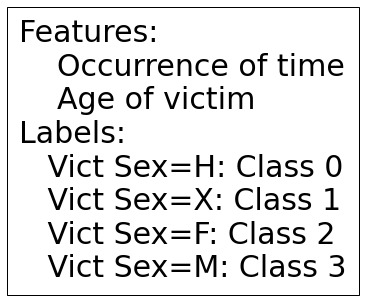

In [99]:
text=[]
text.append("Features:")
for _,f in featuredata:
    text.append("    {0:s}".format(f))
text.append("Labels: ")
for c,n in classdata:
    text.append("   {0:s}={1:s}: Class {2:n}".format(classname,c,n))
textbox(text,fname="multiclass")

In [31]:
classname

'Vict Sex'

In [20]:
(features,revisedfeaturenames)=list(zip(*featuredata))

In [21]:
featuredata

[('TIME OCC', 'Occurrence of time'), ('Vict Age', 'Age of victim')]

In [100]:
XY=pd.DataFrame(0,index=data.index,columns=pd.MultiIndex.from_product([["feature"],revisedfeaturenames]))
for (fname,revisedfeaturename) in featuredata:
    XY[("feature",revisedfeaturename)]=data[fname]


XY[("label","Sex type")]=numpy.nan
for cname,cvalue in classdata:
    XY.loc[data[classname]==cname,("label","Sex type")]=cvalue


beforedrop=XY.shape[0]
XY=XY.dropna(axis='index')
afterdrop=XY.shape[0]
print("{0:d} records dropped".format(beforedrop-afterdrop))
XY[("label","Sex type")]=XY[("label","Sex type")].astype(numpy.int)
XY.head()

0 records dropped


<ipython-input-100-48246f54add3>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  XY[("label","Sex type")]=XY[("label","Sex type")].astype(numpy.int)


feature                  label
  Occurrence of time Age of victim Sex type
0               2230            36        2
1                330            25        3
3               1730            76        2
4                415            31        1
5                 30            25        2

In [101]:
XY.head(6).to_latex(buf="multiclassdata.tex",bold_rows=True,sparsify=False)

In [102]:
X=XY.loc[:,idx["feature",:]]
Y=XY[("label","Sex type")]
X_1=X.iloc[:,0]
X_2=X.iloc[:,1]
_,X_1.name=X_1.name
_,X_2.name=X_2.name
flags=[(Y==c) for c in range(4)]

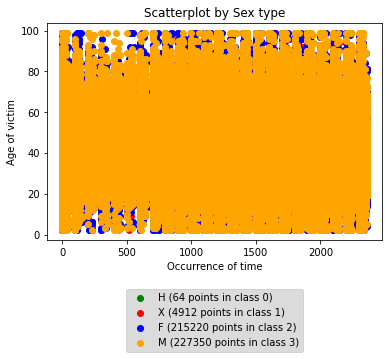

In [103]:
plt.figure()
for (cname,cvalue),f,c in zip(classdata,flags,["green","red","blue","orange"]):
    ff=flags[cvalue]
    plt.scatter(X_1[ff],X_2[ff],color=c,label="{0:s} ({1:d} points in class {2:n})".format(cname,ff.sum(),cvalue))
plt.xlabel(X_1.name)
plt.ylabel(X_2.name)
legend("bottom",ncol=1)
title=[]
(XA,XB)=plt.xlim()
(YA,YB)=plt.ylim()
title.append("Scatterplot by Sex type")
plt.title("\n".join(title))
saver("multiclass_scatterplot")
plt.show()
plt.close()

In [104]:
(m0,b0)=((2,1),3)
(m1,b1)=((-1,0),0)
(m2,b2)=((1,-3),-1)
#(m3,b3)=

In [105]:
def polytope(mb1,mbothers,radius=1):
    #returns vertex and other points to plot in a ball around vertex of radius
    (m1,b1)=mb1
    ((m2,b2),(m3,b3),(m4,b4))=mbothers
    A=numpy.vstack([numpy.array(m1)-numpy.array(m2),numpy.array(m1)-numpy.array(m3)])
    b=numpy.vstack([b1-b2,b1-b3])
    signdet=numpy.sign(numpy.linalg.det(A))
    vertex=numpy.linalg.solve(A,-b).squeeze()
    p1=signdet*numpy.array([-A[0,1],A[0,0]])
    p2=signdet*numpy.array([A[1,1],-A[1,0]])
    dp=(p1-p2)/numpy.linalg.norm(p1-p2)
    nu=2*radius/numpy.linalg.norm(p2-p2.dot(dp)*dp)
    return vertex,[vertex+nu*p1,vertex+nu*p2]

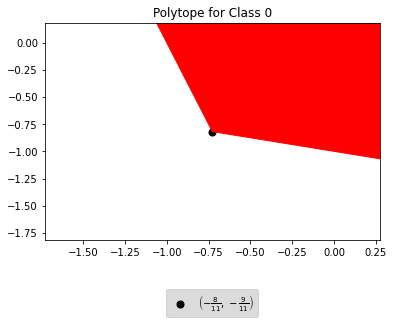

In [106]:
#v,[p1,p2]=polytope((m1,b1),[(m2,b2),(m3,b3)])
v,[p1,p2]=polytope((m0,b0),[(m1,b1),(m2,b2),(m3,b3)])
(xstar,ystar)=v
x,y=zip(*list([v,p1,p2]))

plt.figure()
plt.xlim(xstar-1,xstar+1)
plt.ylim(ystar-1,ystar+1)
plt.fill(x,y,color="red")
plt.scatter(-8/11,-9/11,s=50,color="black",label=r"$\left(-\frac{{8}}{{11}},-\frac{{9}}{{11}}\right)$")
legend("bottom")
title=[]
title.append("Polytope for Class 0")
plt.title("\n".join(title))
saver("polytope")
plt.show()
plt.close()

In [107]:
import sklearn.linear_model

In [108]:
clf = sklearn.linear_model.LogisticRegression(random_state=0,solver="newton-cg").fit(XY.loc[:,idx["feature",:]].values, XY[("label","Sex type")].values)
print(clf.coef_)
print(clf.intercept_)

[[ 8.19283054e-05  2.30753911e-02]
 [-4.89150823e-05 -8.03629975e-02]
 [-4.09243630e-05  2.42509199e-02]
 [ 7.91076128e-06  3.30366864e-02]]
[-5.92887758  1.67342554  2.30709718  1.94835486]


/usr/local/lib/python3.8/dist-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


In [109]:
df_multiclass=pd.DataFrame(numpy.nan,columns=["m1","m2","b"],index=["Class 0","Class 1","Class 2","Class 3"])
df_multiclass.loc[:,"b"]=clf.intercept_
df_multiclass.loc[:,["m1","m2"]]=clf.coef_
df_multiclass.to_latex(buf="multiclasscoeffs.tex",bold_rows=True,header=["$m_1$","$m_2$","b"],escape=False)
df_multiclass

,m1,m2,b
Class 0,0.000082,0.023075,-5.928878
Class 1,-0.000049,-0.080363,1.673426
Class 2,-0.000041,0.024251,2.307097
Class 3,0.000008,0.033037,1.948355


In [110]:
(m0,b0)=(clf.coef_[0],clf.intercept_[0])
(m1,b1)=(clf.coef_[1],clf.intercept_[1])
(m2,b2)=(clf.coef_[2],clf.intercept_[2])
(m3,b3)=(clf.coef_[3],clf.intercept_[3])

In [111]:
clf.coef_

array([[ 8.19283054e-05,  2.30753911e-02],
       [-4.89150823e-05, -8.03629975e-02],
       [-4.09243630e-05,  2.42509199e-02],
       [ 7.91076128e-06,  3.30366864e-02]])

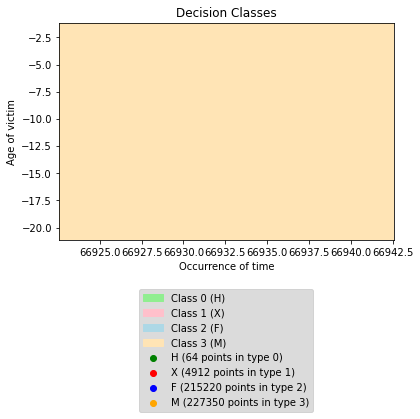

In [112]:
plt.figure()


#first find radius to capture triple point and data
v,_=polytope((m0,b0),[(m1,b1),(m2,b2),(m3,b3)])
(xstar,ystar)=v
(data_mean_x,data_mean_y)=(X_1.mean(),X_2.mean())
(data_std_x,data_std_y)=(X_1.std(),X_2.std())
radius=numpy.linalg.norm([data_mean_x-xstar,data_mean_y-ystar])+2*numpy.linalg.norm([data_std_x,data_std_y])


v,[p1,p2]=polytope((m0,b0),[(m1,b1),(m2,b2),(m3,b3)],radius=radius)

x,y=zip(*list([v,p1,p2]))

plt.xlim(xstar-10,xstar+10)
plt.ylim(ystar-10,ystar+10)
plt.fill(x,y,color="lightgreen",label="Class 0 (H)")

v,[p1,p2]=polytope((m1,b1),[(m2,b2),(m0,b0),(m3,b3)],radius=radius*2)
(xstar,ystar)=v
x,y=zip(*list([v,p1,p2]))
plt.fill(x,y,color="pink",label="Class 1 (X)")

v,[p1,p2]=polytope((m2,b2),[(m0,b0),(m1,b1),(m3,b3)],radius=radius*2)
(xstar,ystar)=v
x,y=zip(*list([v,p1,p2]))
plt.fill(x,y,color="lightblue",label="Class 2 (F)")

v,[p1,p2]=polytope((m3,b3),[(m0,b0),(m1,b1),(m2,b2)],radius=radius*2)
(xstar,ystar)=v
x,y=zip(*list([v,p1,p2]))
plt.fill(x,y,color="moccasin",label="Class 3 (M)")


for (cname,cvalue),f,c in zip(classdata,flags,["green","red","blue","orange"]):
    ff=flags[cvalue]
    plt.scatter(X_1[ff],X_2[ff],color=c,label="{0:s} ({1:d} points in type {2:n})".format(cname,ff.sum(),cvalue))
plt.xlabel(X_1.name)
plt.ylabel(X_2.name)
legend("bottom",ncol=1)


plt.xlabel(X_1.name)
plt.ylabel(X_2.name)
title=[]
title.append("Decision Classes")
plt.title("\n".join(title))
saver("datapolytope")
plt.show()
plt.close()

However, Show as feature: The occurrence of time and age have nothing to do with the label:Sex of victim